In [19]:
import contextily as cx
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio as rio
from rasterio import windows
from rasterio.enums import Resampling
from shapely.geometry import box

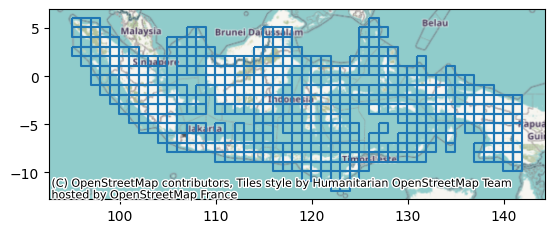

In [10]:
# ROI
# Region of interest
grids = gpd.read_file(
    "https://storage.googleapis.com/gee-ramiqcom-bucket/eo-indonesia/grids.geojson",
)
ax = grids.boundary.plot()
cx.add_basemap(ax, crs="EPSG:4326")

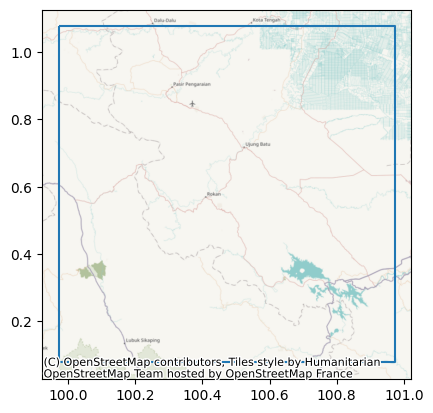

In [11]:
# Select grid no 25
grid_id = 31
roi = grids.iloc[grid_id : grid_id + 1]
ax = roi.boundary.plot()
bbox = roi.union_all().bounds
cx.add_basemap(ax, crs="EPSG:4326")

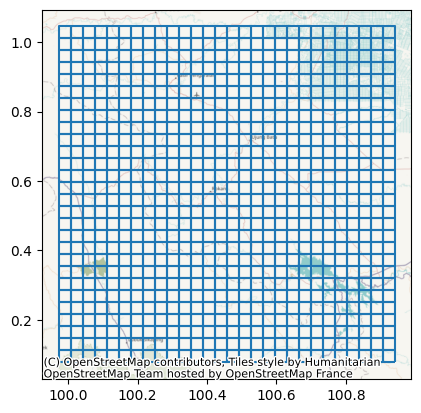

In [12]:
# Create mini grids from grid
distance = (bbox[2] - bbox[0]) / 0.034594
patches = []
for x in range(int(distance)):
    for y in range(int(distance)):
        minx = bbox[0] + (x * 0.034594)
        maxx = minx + 0.034594
        miny = bbox[1] + (y * 0.034594)
        maxy = miny + 0.034594
        polygon = box(minx, miny, maxx, maxy)
        patches.append(polygon)

patches = gpd.GeoDataFrame([], geometry=patches, crs="EPSG:4326")
ax = patches.boundary.plot()
cx.add_basemap(ax, crs="EPSG:4326")

In [16]:
# Data location
modis = "temp/MODIS_Grid-31_2024-05_2024-08.tif"
landsat = "temp/Landsat_Grid-31_2024-05_2024-08.tif"

In [17]:
# Load image
modis_source = rio.open(modis)
landsat_source = rio.open(landsat)

In [23]:
plt.figure(figsize=(20, 50))

# Read image per mini grid
for x in range(len(patches)):
    patch = patches.to_crs(landsat_source.crs).iloc[x]["geometry"]
    bbox_patch = patch.bounds
    window_landsat = windows.from_bounds(
        *bbox_patch,
        transform=landsat_source.transform,
    )
    landsat_image = landsat_source.read(
        boundless=True,
        out_dtype="float32",
        out_shape=(128, 128),
        window=window_landsat,
    )

    with rio.open(
        f"temp/Landsat_Patch-{x + 1}.tif",
        "w",
        "COG",
        count=landsat_image.shape[0],
        width=landsat_image.shape[2],
        height=landsat_image.shape[1],
        compress="lzw",
        resample=Resampling.bilinear,
        nodata=-9999,
        crs="EPSG:4326",
        transform=windows.transform(window_landsat, landsat_source.transform),
        dtype="int16",
    ) as source:
        source.write(landsat_image)

    # out_range = (0, 1)
    # composite_landsat = np.dstack(
    #     [
    #         rescale_intensity(
    #             landsat_image[3],
    #             in_range=(0.1, 0.4),
    #             out_range=out_range,
    #         ),
    #         rescale_intensity(
    #             landsat_image[4],
    #             in_range=(0.075, 0.3),
    #             out_range=out_range,
    #         ),
    #         rescale_intensity(
    #             landsat_image[5],
    #             in_range=(0.025, 0.2),
    #             out_range=out_range,
    #         ),
    #     ],
    # )

    # plt.subplot(25, 8, x * 2 + 1)
    # plt.imshow(composite_landsat)

    window_modis = windows.from_bounds(
        *bbox_patch,
        transform=modis_source.transform,
    )
    modis_image = modis_source.read(
        boundless=True,
        out_dtype="float32",
        out_shape=(8, 8),
        window=window_modis,
    )

    # composite_modis = np.dstack(
    #     [
    #         rescale_intensity(
    #             modis_image[3],
    #             in_range=(0.1, 0.4),
    #             out_range=out_range,
    #         ),
    #         rescale_intensity(
    #             modis_image[4],
    #             in_range=(0.075, 0.3),
    #             out_range=out_range,
    #         ),
    #         rescale_intensity(
    #             modis_image[5],
    #             in_range=(0.025, 0.2),
    #             out_range=out_range,
    #         ),
    #     ],
    # )
    # plt.subplot(25, 8, x * 2 + 2)
    # plt.imshow(composite_modis)

    with rio.open(
        f"temp/MODIS_Patch-{x + 1}.tif",
        "w",
        "COG",
        count=modis_image.shape[0],
        width=modis_image.shape[2],
        height=modis_image.shape[1],
        compress="lzw",
        resample=Resampling.bilinear,
        nodata=-9999,
        crs="EPSG:4326",
        transform=windows.transform(window_modis, modis_source.transform),
        dtype="int16",
    ) as source:
        source.write(modis_image)

<Figure size 2000x5000 with 0 Axes>